In [39]:
# Import required modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

# SECTION 1 - Camera Calibration

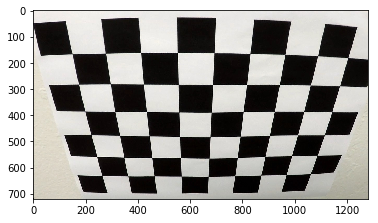

In [55]:
# Read in an example calibration image
img = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(img)

Processing image camera_cal\calibration1.jpg
Processing image camera_cal\calibration10.jpg
Corners found for image camera_cal\calibration10.jpg
Processing image camera_cal\calibration11.jpg
Corners found for image camera_cal\calibration11.jpg
Processing image camera_cal\calibration12.jpg
Corners found for image camera_cal\calibration12.jpg
Processing image camera_cal\calibration13.jpg
Corners found for image camera_cal\calibration13.jpg
Processing image camera_cal\calibration14.jpg
Corners found for image camera_cal\calibration14.jpg
Processing image camera_cal\calibration15.jpg
Corners found for image camera_cal\calibration15.jpg
Processing image camera_cal\calibration16.jpg
Corners found for image camera_cal\calibration16.jpg
Processing image camera_cal\calibration17.jpg
Corners found for image camera_cal\calibration17.jpg
Processing image camera_cal\calibration18.jpg
Corners found for image camera_cal\calibration18.jpg
Processing image camera_cal\calibration19.jpg
Corners found for 

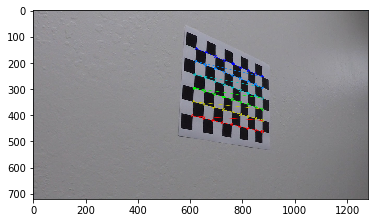

In [56]:
# Take in all the pictures of the chess board from the camera_cal folder.
# Use these pictures to calibrate the camera by creating the distortion matrix.

# Initialise empty arrays to hold..
# Object points - these are the real location of the points
# image points - these are the location of the points in the distorted image.
object_points = [] # 3d space
image_points = [] # 2d space

# Set the size of the chess board used in the calibration
# Remember to only count inside corners.
num_rows = 6
num_cols = 9 

images = glob.glob('camera_cal/calibration*.jpg')
for image in images:
    
    print('Processing image {}'.format(image))
    
    input_image = mpimg.imread(image)
    
    objp = np.zeros((num_rows*num_cols, 3), np.float32)
    objp[:,:2] = np.mgrid[0:num_cols, 0:num_rows].T.reshape(-1,2)

    # Convert the grayscale for finding the corners.
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

    
    # Find the chess board in the pictures
    ret, corners = cv2.findChessboardCorners(gray_image, (num_cols, num_rows), None)

    # Append points for each image
    if ret == True:
        print('Corners found for image {}'.format(image))
        image_points.append(corners)
        object_points.append(objp)

        # Option to draw the corners onto the image. Good to check and for write up.
        found_corners = cv2.drawChessboardCorners(input_image, (num_cols, num_rows), corners, ret)
        plt.imshow(found_corners)


Could not find corners for calibration4, calibration5 and calibration1

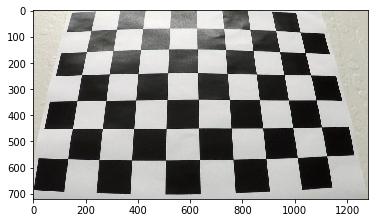

In [85]:
# Use the points found above for calibration.
image = mpimg.imread('camera_cal/calibration3.jpg')
plt.imshow(image)

In [86]:
def undistort_image(image, object_points, image_points):
    # Now calcualte the distortion coef and matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image.shape[1:], None, None )
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted

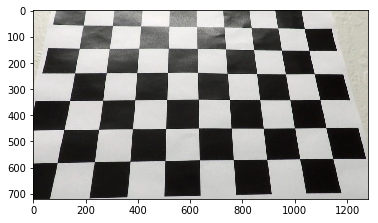

In [87]:
undistorted= undistort_image(image, object_points, image_points)
plt.imshow(undistorted)

In [ ]:
# Im not sure if my distorition works because it doesn't change it much. 
# Move on for now. 

# Section 2 - Thresholded binary image (color transforms and gradients)

In [101]:
# Gradient thresholds first

# Using the starter code from the tutorials

# Apply gradient threshold separately for x and y direction
def abs_sobel_thresh(image, orient ='x', sobel_kernel =3, thresh = (0,255)):
    
    '''
    Using the sobel matrix to calculate gradients in either the x or y direction.
    Then only retain where the gradient is above or below a certain threshold.
    inputs
    - image
    - sobel_kernel - increase to reduce noise
    - threshold(min,max) - threshold values to remove. 
    
    output - image showing where theshold gradient is. 
    
    '''
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #calculate the directional gradient
    if orient == 'x':
         sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # Calculate the absolute value
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/ np.max(abs_sobel))
                            
    # apply threshold.
    # create a binary mask
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
                                                
    return binary

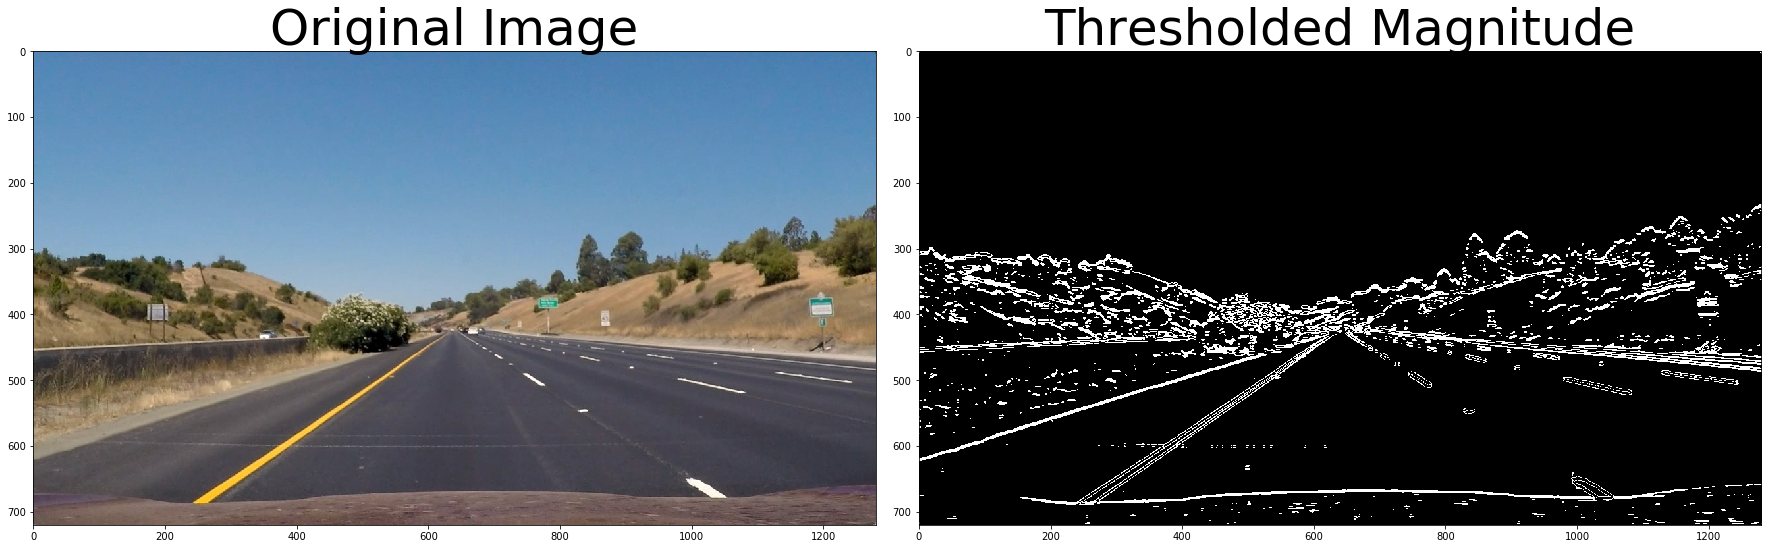

In [130]:
# Test abs_sobel_thresh function
image = mpimg.imread('test_images\straight_lines1.jpg')
x_gradient_threshold = abs_sobel_thresh(image, orient ='y', sobel_kernel =9, thresh = (30,100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(x_gradient_threshold, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [103]:
def mag_thresh(image, sobel_kernel = 3, mag_thresh = (0,255)):
    '''
    Using the sobel matrix to calculate gradients in both the x and y direction
    to find the magnitude of the overall gradient. 
    Then only retain where the gradient is above or below a certain threshold.
    inputs
    - image
    - sobel_kernel - increase to reduce noise
    - threshold(min,max) - threshold values to remove. 
    
    output - image showing where theshold gradient is.
    
    Source - Magnitude of Gradient - Udacity Course
    
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scale = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # 5) Create a binary mask where mag thresholds are met
    binary = np.zeros_like(sobel_scale)
    binary[(sobel_scale >= mag_thresh[0]) & (sobel_scale <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary
    

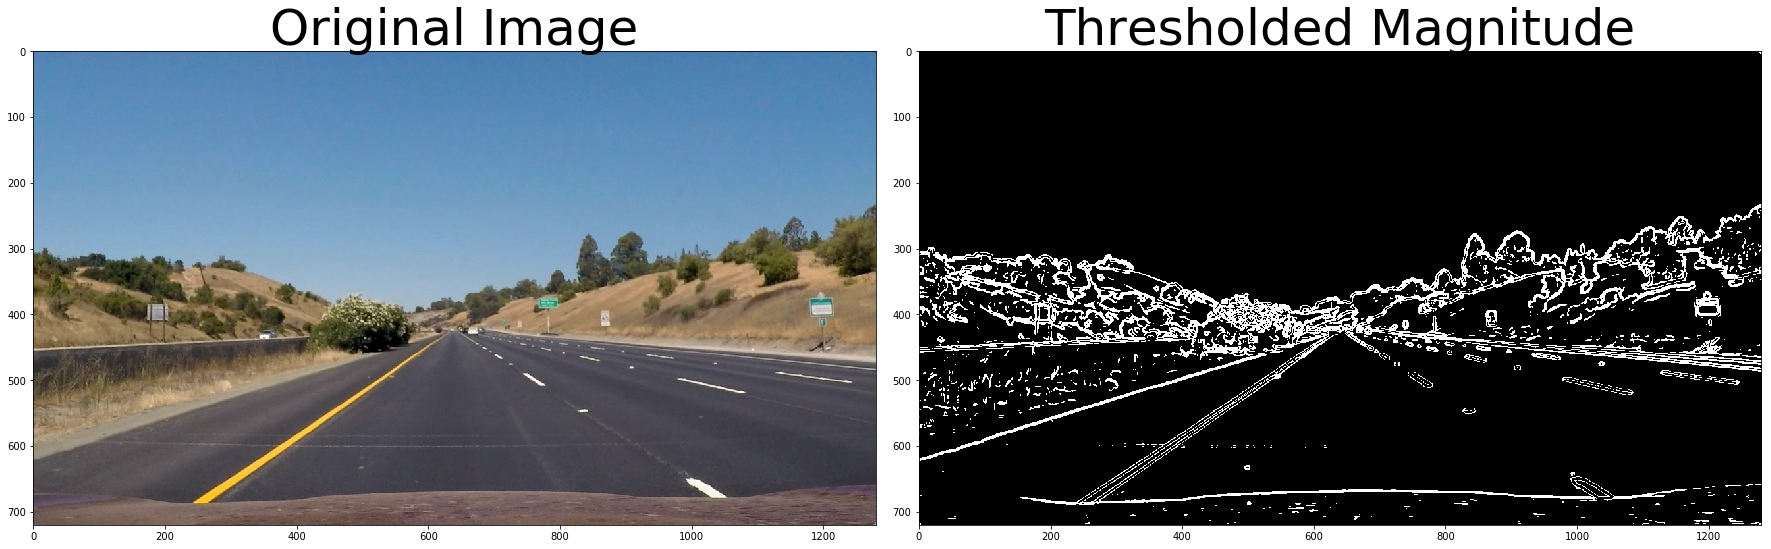

In [104]:
# Test abs_sobel_thresh function
image = mpimg.imread('test_images\straight_lines1.jpg')
magnitude_threshold = mag_thresh(image, sobel_kernel =9, mag_thresh = (30,100))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(magnitude_threshold, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [108]:
def dir_threshold(image, sobel_kernel=3, thresh = (0, np.pi/2)):
    '''
    Using the sobel matrix to calculate gradients in both the x and y direction
    to find the magnitude of the overall gradient. 
    Then only retain where the gradient is above or below a certain threshold.
    inputs
    - image
    - sobel_kernel - increase to reduce noise
    - threshold(min,max) - threshold values to remove. 
    
    output - image showing where theshold gradient is. 
    
    Source - Direction of Gradient - Udacity Course
    '''
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    
    binary = np.zeros_like(direction)
    binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary
    
    

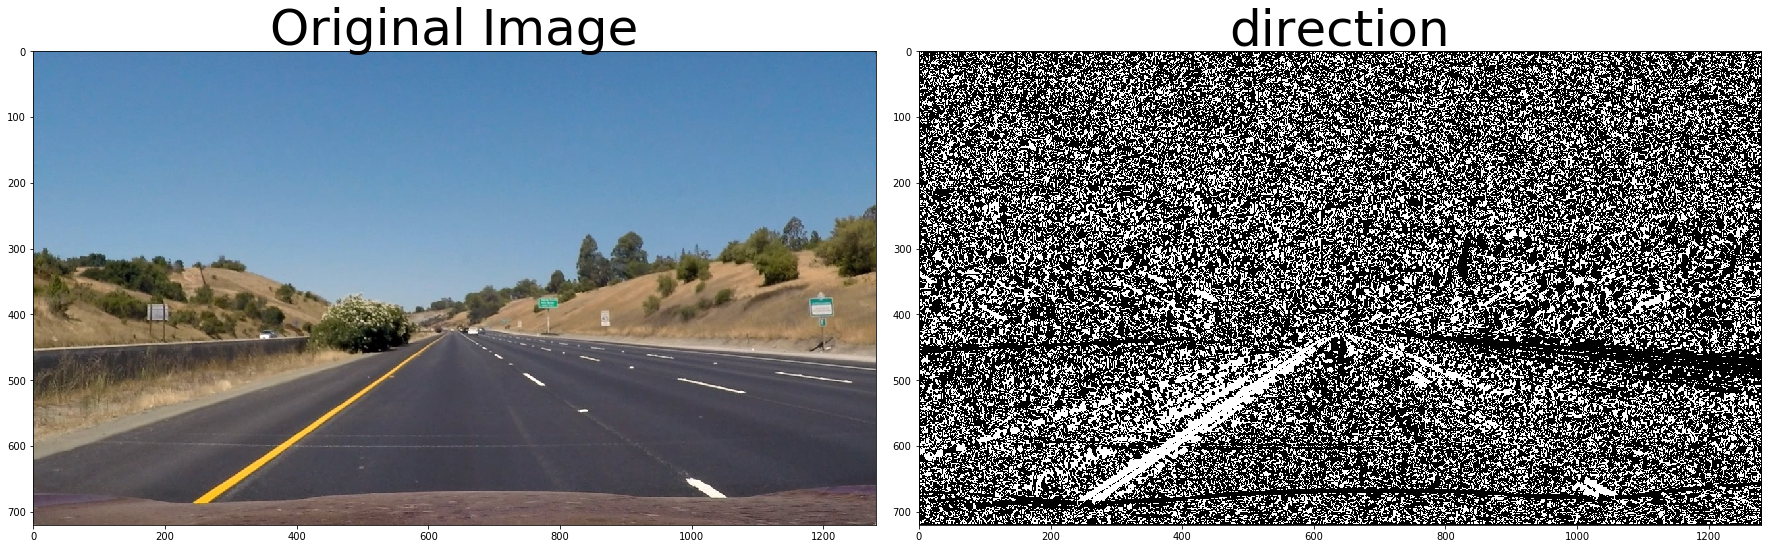

In [163]:
# Test abs_sobel_thresh function
image = mpimg.imread('test_images\straight_lines1.jpg')
direction_threshold = dir_threshold(image, sobel_kernel =15, thresh = (0.8,1.3))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(direction_threshold, cmap='gray')
ax2.set_title('direction', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [164]:
# Color Transforms and thresholds. Apply a threshold to S in HLS
def R_threshold(image, thresh= (200, 255)):

    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
 
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def S_threshold(image, thresh = (90, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    return binary 



6 binarys to combine
    - x gradients thresholded
    - y gradients thresholded
    - Gradients magnitude
    - Gradient direction
    - S in HLS threshold
    - R in RGb threshold


In [165]:
image = mpimg.imread('test_images\straight_lines1.jpg')


x_gradient_threshold = abs_sobel_thresh(image, orient ='x', sobel_kernel =9, thresh = (30,100))
y_gradient_threshold = abs_sobel_thresh(image, orient ='y', sobel_kernel =9, thresh = (30,100))
magnitude_threshold = mag_thresh(image, sobel_kernel =9, mag_thresh = (30,100))
direction_threshold = dir_threshold(image, sobel_kernel =15, thresh = (0.7,1.3))
R_thresh = R_threshold(image, thresh = (200, 255) )
S_thresh = S_threshold(image, thresh = (90, 255))

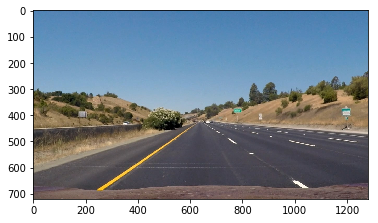

In [166]:
plt.imshow(image)

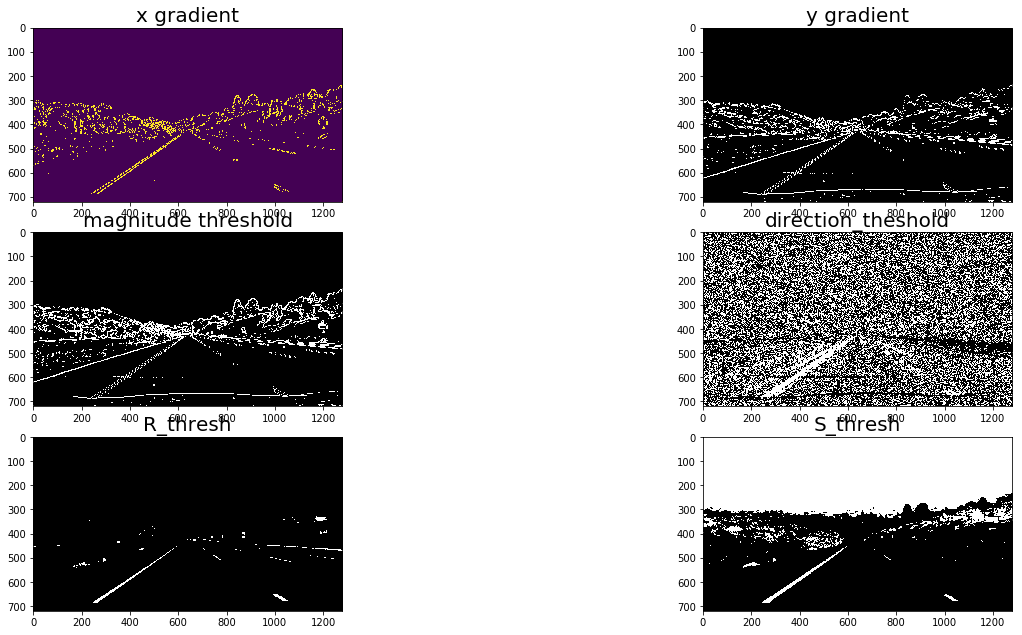

In [167]:
f, ((ax1, ax2 ), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(x_gradient_threshold)
ax1.set_title('x gradient', fontsize=20)
ax2.imshow(y_gradient_threshold, cmap='gray')
ax2.set_title('y gradient', fontsize=20)
ax3.imshow(magnitude_threshold, cmap='gray')
ax3.set_title('magnitude threshold', fontsize=20)
ax4.imshow(direction_threshold, cmap='gray')
ax4.set_title('direction_theshold', fontsize=20)
ax5.imshow(R_thresh, cmap='gray')
ax5.set_title('R_thresh', fontsize=20)
ax6.imshow(S_thresh, cmap='gray')
ax6.set_title('S_thresh', fontsize=20)


plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

So we can tweak the thresholds and then we can combine. 

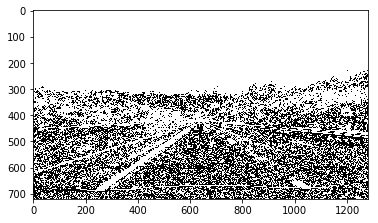

In [145]:
# How to combine

# Combine the two binary thresholds
combined_binary = np.zeros_like(x_gradient_threshold)
combined_binary[(x_gradient_threshold == 1) | 
                (y_gradient_threshold == 1) |
                (magnitude_threshold == 1) |
                (direction_threshold == 1) |
                (R_thresh == 1) |
                (S_thresh == 1) 
               ] = 1

plt.imshow(combined_binary, cmap='gray')


In [ ]:
# Feels pretty noisy right now. But it's a binary image. lets keep going for now. 

# Section 3 - Perspective Transform

In [ ]:
def perspective_transform(image):
    offset = 100
    img_size = (image.shape[1], image.shape[0])
    
    # How to set the 4 source positions when not a chessboard?
    #### HOW TO GET SOURCE AND DESTINATION ###### 
    source = 
    
    # I could just eyeball a rectangle in the future image. 
    destination = 
    
    M = cv2.getPerspectiveTransform(source, destination)
    
    warped = cv2.warpPerspective(image, M, img_size)
    
    return warped
    